## Vehicle detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage.feature import hog as sk_hog

PIX_PER_CELL=16
CELL_PER_BLOCK=2

def gray(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)[:,:,0] # 1st YCrCb channel, just for test

def hog(image, pix_per_cell = PIX_PER_CELL, cell_per_block = CELL_PER_BLOCK, orient = 11, vis = False, fvect=True):
    if (vis):
        features, hog_image = sk_hog(image, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block),
                          visualise=vis, feature_vector=fvect,transform_sqrt=False,
                          block_norm="L2-Hys")
        return features, hog_image
    else:
        features = sk_hog(image, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block),
                          visualise=vis, feature_vector=fvect,transform_sqrt=True,
                          block_norm="L2-Hys")
        return features


def hog_gray(img):
    return hog(gray(img))

def hog_imread(img):
    return hog_gray(cv2.imread(img))
    


In [2]:
def color_hists(img):
    R = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    G = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    B = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    return np.concatenate((R[0],G[0],B[0]))
def ycr_hists(img):
    Y = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    Cr = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    Cb = np.histogram(cv2.equalizeHist(img[:,:,2]), bins=32, range=(0, 256))
    return np.concatenate((Y[0],Cr[0],Cb[0]))
def s_hist(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #H = np.histogram(hsv[:,:,0], bins=32, range=(0, 256))
    S = np.histogram(hsv[:,:,1], bins=32, range=(0, 256))
    #V = np.histogram(hsv[:,:,2], bins=32, range=(0, 256))
    return S[0]#np.concatenate((H[0], S[0], V[0]))
    
def spatial_bin(img):
    return cv2.resize(img, (8, 8)).ravel()

In [3]:
def hogs(img, fvect=True):
    imgs = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    hg1 = hog(imgs[:,:,0], fvect=fvect)
    hg2 = hog(imgs[:,:,1], fvect=fvect)
    hg3 = hog(imgs[:,:,2], fvect=fvect)
    return(hg1, hg2, hg3)

def all_hist(img):
    col = color_hists(img)
    spat = spatial_bin(img)
    s= s_hist(img)
    ycr = ycr_hists(cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb))
    luv = color_hists(cv2.cvtColor(img,cv2.COLOR_BGR2LUV))
    return (np.concatenate((s, col, spat, ycr)))#, luv)))col
def all_img(img):
    image = img#cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #image = img #cv2.cvtColor(img,cv2.COLOR_RGB2BGR)#cv2.equalizeHist(img)
    hg1, hg2, hg3 = hogs(image)
    col=all_hist(image)#, spat, s , ycr, luv= all_hist(img)
    out = np.concatenate((hg1, hg2, hg3, col))#, spat, s, ycr, luv))

    return out

def all_imread(pth):
    return (all_img(cv2.cvtColor(cv2.imread(pth), cv2.COLOR_RGB2BGR)))

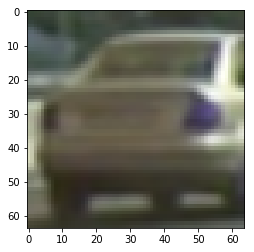

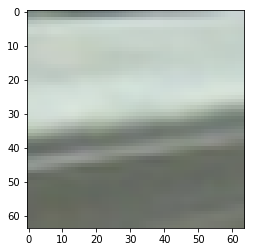

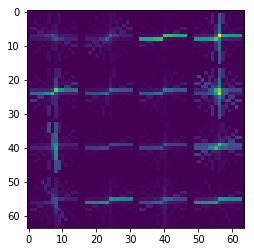

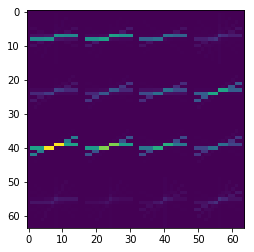

In [4]:
origin = cv2.imread("examples/image0009.png")
origin2 = cv2.imread("examples/image1011.png")

features, image = hog(gray(origin), vis=True)
features2, image2 = hog(gray(origin2), vis=True)


plt.imshow(origin)
plt.show()
plt.imshow(origin2)
plt.show()

plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

def normalize(X):
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    return (X_scaler.transform(X), X_scaler)

In [6]:
feature1, feature2 = all_img(origin), all_img(origin2)
feature_list = [feature1, feature2, feature2,feature1, feature2, feature2]
print(feature1.shape)
# Create an array stack, NOTE: StandardScaler() expects np.float64
X = np.vstack(feature_list).astype(np.float64)

#(scaled_t, scaler_t)=normalize(X)



(1604,)


In [7]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import glob
from sklearn.utils import shuffle
from multiprocessing import Pool, Process

images1 = glob.glob('training/vehicles/*/*.png')
images2 = glob.glob('training/non-vehicles/*/*.png')


feat = []
ress =[]


#print(cv2.imread(images1[1]))


In [8]:
pool = Pool(4)

ress = [1]*len(images1) + [0]*len(images2)
feat = pool.map_async(all_imread, images1)

In [9]:
pool2 = Pool(4)
feat2 = pool2.map_async(all_imread, images2)
pool.close()
pool.join()
pool2.close()
pool2.join()
feats1=  feat.get()
feats2= feat2.get()
feats=feats1 + feats2

In [10]:
feats, ress = shuffle (feats, ress)
    
X = np.vstack(feats).astype(np.float64)

scaled, scaler = normalize(X)

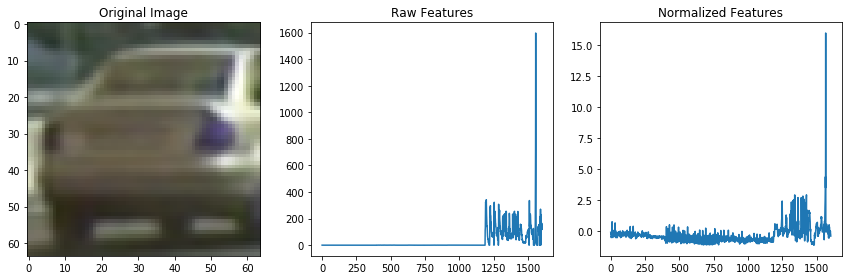

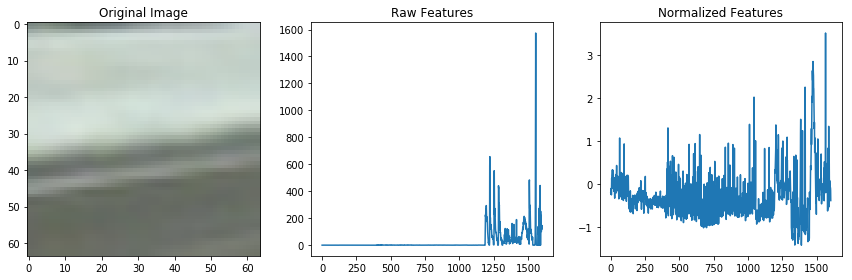

In [11]:
for (num, img) in enumerate([origin, origin2]):
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[num])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled[num])
    plt.title('Normalized Features')
    fig.tight_layout()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
parameters = {}#'tol':[.001, .01]
#svr = DecisionTreeClassifier(class_weight={0:0.1,1:50})#
#svr = svm.LinearSVC(C=0.001)#C=0.01)
#clf = GridSearchCV(svr, parameters)
#clf.fit(X, ress)
tx, testx, ty, testy =  train_test_split(scaled, ress)

In [13]:
#clf_scaled = RandomizedSearchCV(svr, parameters, n_iter=1, n_jobs=8)
#clf_scaled.fit(tx, ty)
from sklearn.neural_network import MLPClassifier

clf_scaled = MLPClassifier()
clf_scaled.fit(tx, ty)

#print(clf_scaled.best_params_)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [14]:
e=clf_scaled.predict (testx)
#pred =c==ress
pred2 = e == testy
n=0
 
for num, i in enumerate(pred2):
    if not i:
        #print (e[num])
        n+=1
accuracy = ((len(ress)-n)/len(ress))
print(accuracy)

0.9984234234234234


In [15]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), y_factor=1, xy_overlap=(0.5, 0.5), scale=1):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    y=1
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = (xs*nx_pix_per_step + x_start_stop[0])/y
            endx = (startx + xy_window[0])*y
            starty = (ys*ny_pix_per_step + y_start_stop[0])/y
            endy = (starty + xy_window[1])*y
            # Append window position to list
            window_list.append(((int(startx), int(starty)), (int(endx), int(endy)), scale))
        y*=y_factor
    # Return the list of windows
    return window_list
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


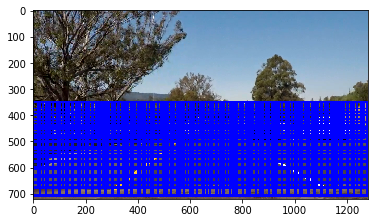

In [16]:
#image = cv2.imread('test_images/test1.jpg')
image = cv2.imread('orig176.png')

lis=slide_window(image, y_start_stop = [350, 500], xy_window = (64,64), xy_overlap = (0.6,0.6),y_factor=1, scale=1)
#lis+=slide_window(image, y_start_stop = [400, 500], xy_window = (32,32), xy_overlap = (0.5,0.5),y_factor=1, scale=0)
lis+=slide_window(image, y_start_stop = [350, 700], xy_window = (96,96), xy_overlap = (0.8,0.6),y_factor=1, scale=2)

lis+=slide_window(image, y_start_stop = [350, image.shape[0]], xy_window = (128,128), xy_overlap = (0.8,0.8),y_factor=1, scale=3)
lis+=slide_window(image, y_start_stop = [350, image.shape[0]], xy_window = (256,256), xy_overlap = (0.8,0.8),y_factor=1, scale=3)



img = draw_boxes(image, lis, color=(0, 0, 255), thick=6)
plt.imshow(img)
plt.show()


In [17]:
from functools import partial

def try_window(window, img):
    img=cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
    features = all_img(img)
    return scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
    #return clf_scaled.predict(scaled)
    #if pred==1:
        #if clf_scaled.decision_function(scaled)> .2:
    #        return True
    #return False

def search_windows(img, windows, scaler, clf_scaled, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK):
    on_windows = []

    try_window_loaded=partial(try_window, img=img)

    pool=Pool(8)
    feats=pool.map(try_window_loaded, windows)

    #pred=clf_scaled.predict(feats)
    
    for feat, window in zip(feats, windows):
        #try:
        if clf_scaled.predict(feat) ==1:
            on_windows.append(window)

    return on_windows

In [18]:
chosen_win = search_windows(image, lis, scaler, clf_scaled)

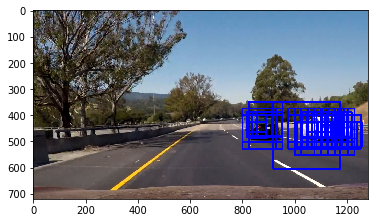

In [19]:
img = draw_boxes(image, chosen_win,  color=(0, 0, 255), thick=6)
plt.imshow(img)
plt.show()

In [20]:
def add_heat(img, bbox_list):
    # Iterate through list of bboxes
    heatmap = np.zeros_like(img)
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def thresh(img, threshold):
    img[img <= threshold]=0
    return img

In [21]:
from scipy.ndimage.measurements import label


In [22]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [23]:
from multiprocessing import Process, Manager
def worker(image, ns):
    #print(1)
    #print(lis)
    ns.lista=search_windows(image, ns.lis, ns.scaler, ns.clf_scaled)
    #print(l)
    #for w in l:
        #print(w)
     #   ns.lista.append(w)

def spawner(image):
    return_list = Manager().Namespace()
    return_list.lista=[]
    return_list.lis = lis
    return_list.scaler = scaler
    return_list.clf_scaled=clf_scaled
    p = Process(target=worker, args=(image,return_list))
    p.start()
    p.join()
    #print(return_list.lista)
    return (return_list.lista)

In [24]:
#from random import randint
from collections import deque

N= 20  # number of frames to store
stored_heat = deque(maxlen = N)

oldheat=[]
def process_image(image, show=False):
    global oldheat
    threshold=3 
    #chosen_win = search_windows(image, lis, scaler, clf_scaled)
    chosen_win = spawner(image)
    heat = add_heat(image, chosen_win)
    stored_heat.append(heat)
    if (not show):
        #print(oldheat)
        threshold+= int((20-len(stored_heat))/5) #rise threshold if there are few frames
        #heat+=(np.uint8(heat/1.1))
        heat=np.uint8(sum(stored_heat)/len(stored_heat))
    if show:

            plt.imshow(heat*50)
            plt.show()
    tr = thresh(heat, threshold)
    #cv2.imwrite("heat"+str(randint(0,1000))+".png", heat)
    #cv2.imwrite("orig"+str(randint(0,1000))+".png", image)

    lab = label(tr)
    
    if not show:
        oldheat = heat
    drw =  draw_labeled_bboxes(image, lab)
    if show:

            plt.imshow(lab[0].astype(np.uint8)*50)
            plt.show()
    #cv2.imwrite("drw"+str(randint(0,1000))+".png", drw)

            plt.imshow(drw)
            plt.show()
    return drw


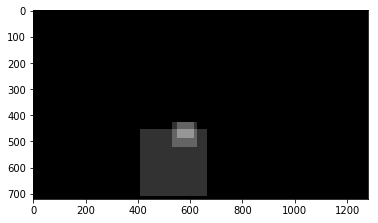

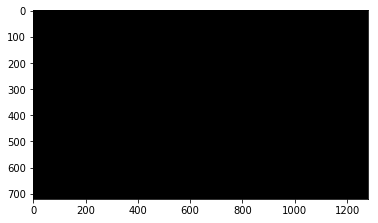

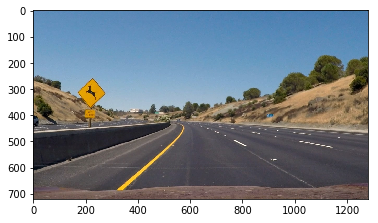

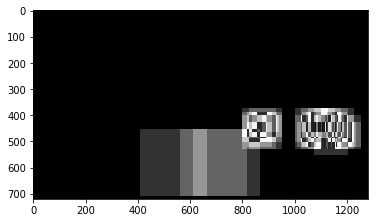

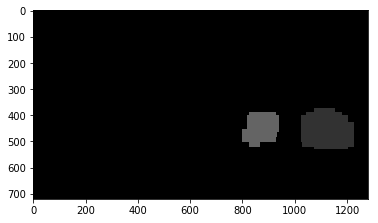

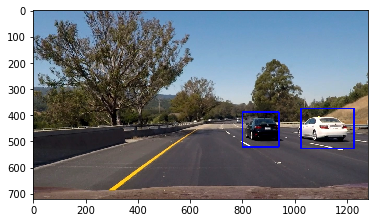

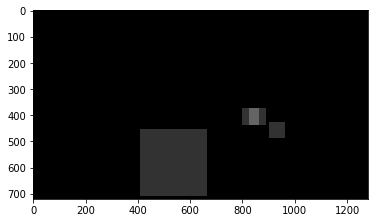

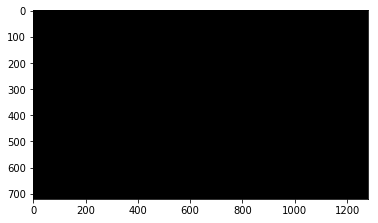

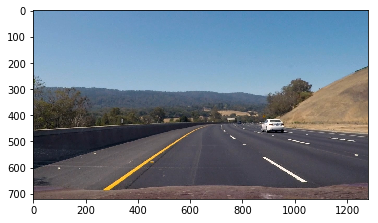

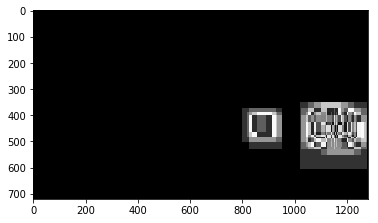

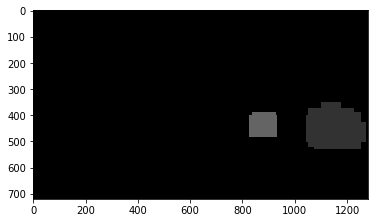

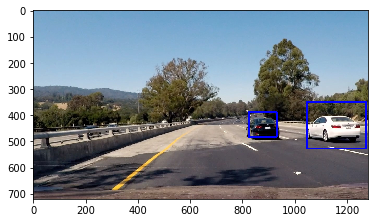

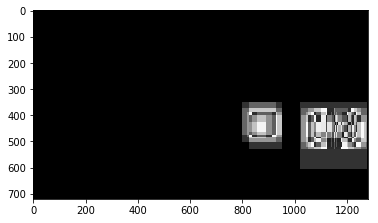

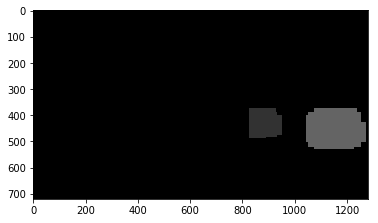

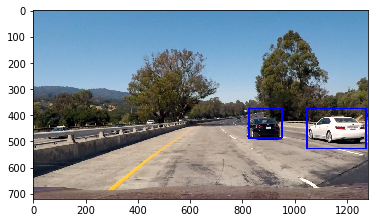

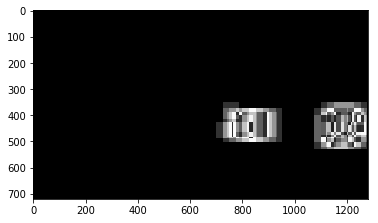

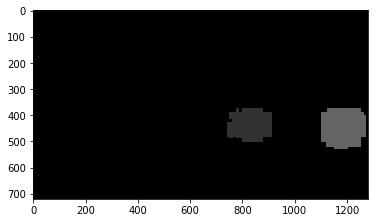

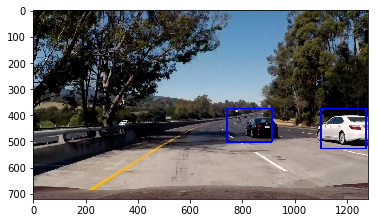

In [25]:
for img in glob.glob("test_images/*"):
    global oldheat
    oldheat=[]
    image=cv2.cvtColor(cv2.imread(img), cv2.COLOR_RGB2BGR)
    process_image(image, show=True)

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(input_vid, output_vid):
    global oldheat
    oldheat = []
    clip1 = VideoFileClip(input_vid)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_vid, audio=False)

In [27]:
stored_heat = deque(maxlen = N)
process_video('test_video.mp4', 'out/test_video.mp4')

[MoviePy] >>>> Building video out/test_video.mp4
[MoviePy] Writing video out/test_video.mp4


 97%|█████████▋| 38/39 [01:06<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/test_video.mp4 

CPU times: user 4.61 s, sys: 1.28 s, total: 5.89 s
Wall time: 1min 7s


In [28]:
stored_heat = deque(maxlen = N)
process_video('project_video.mp4', 'out/project_video.mp4')

[MoviePy] >>>> Building video out/project_video.mp4
[MoviePy] Writing video out/project_video.mp4


100%|█████████▉| 1260/1261 [36:57<00:01,  1.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out/project_video.mp4 

CPU times: user 2min 13s, sys: 44.5 s, total: 2min 57s
Wall time: 36min 58s
